# Princeton Web Census Interface
## *About:*
This jupyter notebook provides an interface for interacting with data from the Princeton Web Census.

For questions or comments, feel free to email dill.reisman@gmail.com, or open up an issue on [our Github repo](https://github.com/dreisman/WebCensusNotebook).

## *How to use:*
To execute a cell, select/click it, and either press the 'play' button in the top tool bar or use the keyboard shortcut shift+enter

## *Warning:*
This interface is optimized for fast exploration of individual first parties and third parties. Actions that require a lot of data from many third parties/first parties can get slow. For instance, we do not recommend attempting to get all third party resources on more than 10000 first parties all at once, unless you intend to wait. We recommend sampling where you can, and estimating how many first parties and third parties you might be accessing before fully executing a command.


## *Getting started:*

Run the cell below to create a `Census` object, which provides the interface for accessing the web census data for a particular web census crawl. Everything you need is encapsulated by this object.

For instance, if you want to get information about a particular third party, you can access it through Census.third_parties['thirdparty.com'].

For information about a first party, you can access Census.first_parties['firstparty.com'].

For information about a particular known Organization, you can access Census.organizations['Org Name'].

All objects you access provide many properties you can explore, from the Alexa rank of a first party to the third party resources that a first party embeds on the site, and which of those third party resources are trackers. The best way to learn about our data is to explore the interface.

## *Available census crawls:*
When more censuses are available, you can set census_name to the desired census in the first code cell below.

* "census_2016_10_1m_stateless": A crawl of the top 1M sites from October 2016. Browser state (cookies, localstorage, etc.) was cleared between each site visit.

(census_2016_01_1m_stateless [January 2016] by end-of-week [6/16/17]. January 2017 and May 2017 coming soon.)


## *Execute this cell first!*

In [1]:
### Select it and hit shift+enter. It'll take approx. 10 seconds to initialize.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
sys.path.append(os.path.realpath('censuslib'))
from censuslib import census

# Note: If you'd like to access one of our other databases, replace census_name
# with one of our other available crawls listed above
census_name = 'census_2016_10_1m_stateless'

# the 'cen' Census object provides the interface for interacting with
# census data
cen = census.Census(census_name)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Basic use of the interface
You can append '?' to the end of an object to get a description of the object. Each object has many properties that can aid you in analyzing the data. Try running the below cells to learn more about the different objects you can access and their properties:

In [ ]:
# The top level census object
cen?

In [ ]:
# A container of all FirstParties visited in the census
cen.first_parties?

In [ ]:
# A container of all ThirdParties visited in the census
cen.third_parties?

In [ ]:
# A particular FirstParty visited in the census 
nytimes = cen.first_parties['nytimes.com']
nytimes?

In [ ]:
# A container of ThirdParties found on a particular FirstParty
nytimes_tps = cen.first_parties['nytimes.com'].third_parties
nytimes_tps?

In [ ]:
# A list of instances (URIs) of third parties found on a particular FirstParty
nytimes_tp_uris = cen.first_parties['nytimes.com'].third_party_resources
single_resource = nytimes_tp_uris[0]
single_resource?

In [ ]:
# A particular ThirdParty observed in the census
optimizely = cen.third_parties['optimizely.com']
optimizely?

In [ ]:
# A container of FirstParties that have a particular ThirdParty
optimizely_org = cen.third_parties['tiqcdn.com'].organization
optimizely_org?

### Example: The average number of third party domains by Alexa category

Average number of third party domains on reference sites: 17.23
Average number of third party domains on regional sites: 25.37
Average number of third party domains on computers sites: 17.45
Average number of third party domains on news sites: 46.84
Average number of third party domains on society sites: 29.17
Average number of third party domains on shopping sites: 27.78
Average number of third party domains on adult sites: 9.38
Average number of third party domains on arts sites: 36.37
Average number of third party domains on sports sites: 32.37
Average number of third party domains on games sites: 27.81
Average number of third party domains on home sites: 34.64
Average number of third party domains on health sites: 19.97
Average number of third party domains on business sites: 23.62
Average number of third party domains on kids_and_teens sites: 25.62
Average number of third party domains on science sites: 17.81
Average number of third party domains on recreation sites: 26.83


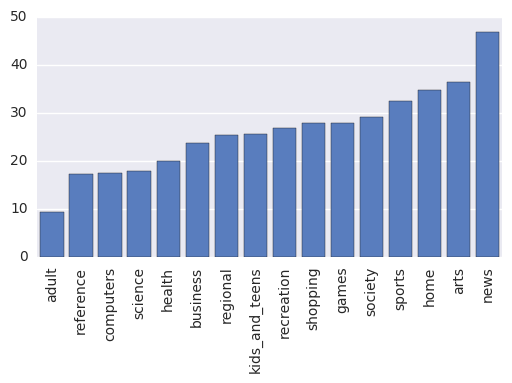

In [2]:
# Approx. 10-15 seconds to run.
import seaborn as sns
res = dict()
for category in cen.first_parties.alexa_categories:
    avg = sum(len(set(tp.domain for tp in fp.third_party_resources))
              for fp in cen.first_parties.alexa_categories[category][:100]) / 100
    
    print("Average number of third party domains on " + category + " sites: " + str(avg))
    res[category] = avg
res = sorted(res.items(), key=lambda x: x[1])
sns.set_style('darkgrid')
sns.set_color_codes('muted')
bar_plot = sns.barplot(x=[c[0] for c in res], y=[c[1] for c in res], color='b')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=.3)

### Example: Top organizations present on a sample of first parties

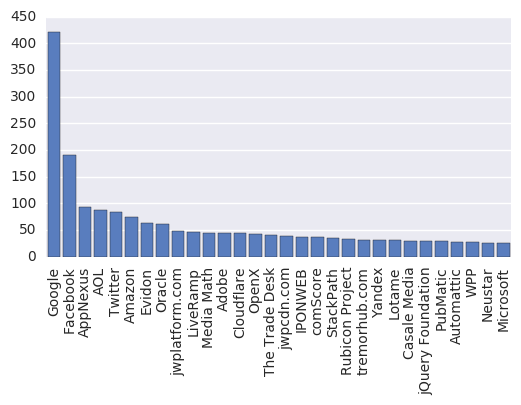

In [3]:
# Approx. 10-15 seconds to run
import random
from collections import Counter

# Get sample_size sites from top_n sites
sample_size = 500
top_n = 10000
sample = random.sample([x for x in cen.first_parties[:top_n]], sample_size)

# Count occurrences of an organization across first parties in sample
res = Counter()
for first_party in sample:
    res.update(set(tp.organization.name for tp in first_party.third_parties))

# Draw graph
res = sorted(res.items(), key=lambda x: x[1], reverse=True)[:30]
sns.set_style('darkgrid')
sns.set_color_codes('muted')
bar_plot = sns.barplot(x=[c[0] for c in res], y=[c[1] for c in res], color='b')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=.3)

### Example: The average number of trackers on the top 100 first parties

In [ ]:
top_n = 100
avg = len([tp for fp in cen.first_parties[:top_n] for tp in fp.third_party_resources if tp.is_tracker]) / top_n
avg

# Play with the interface below!

In [ ]:
cen